<a href="https://colab.research.google.com/github/Sim98B/TabularDataGeneration/blob/main/BrainTumor/BrainTumorConditionalImageGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Conditional Image Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Breast-Cancer-Data)
3. [A stronger model](#Wassesrstein-GAN-with-Gradient-Penalty)
4. [Are the data good enough?](#Data-Evaluation)
5. [Validation Protocol](#TOR-TS-protocol)
6. [Latent Evaluation](#Principal-Component-Analysis)
7. [Conclusion](#Conclusion)

In [2]:
import sys
import os
import shutil

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

import random
from tqdm.auto import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

In [3]:
!git clone https://github.com/Sim98B/TabularDataGeneration.git

to_keep_files = ['BrainTumor', 'utils.py', '.git']
base_dir = 'TabularDataGeneration'

for item in os.listdir(base_dir):
    item_path = os.path.join(base_dir, item)

    if item not in to_keep_files:
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            import shutil
            shutil.rmtree(item_path)

sys.path.append("TabularDataGeneration")
import utils

Cloning into 'TabularDataGeneration'...
remote: Enumerating objects: 4080, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 4080 (delta 74), reused 49 (delta 34), pack-reused 3968 (from 1)
Receiving objects: 100% (4080/4080), 125.05 MiB | 28.87 MiB/s, done.
Resolving deltas: 100% (505/505), done.


In [329]:
tumor_mapping = {0: 'Clear', 1: 'Glioma', 2: 'Meningioma', 3: 'Pituitary'}
section_mapping = {0: 'Axial', 1: 'Coronal', 2: 'Sagittal'}

feature_dim = 64
BS = 64

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []  # (tumor_type, section_type)

        tumor_types = sorted(os.listdir(root_dir))
        self.tumor_dict = {tumor: i for i, tumor in enumerate(tumor_types)}

        for tumor in tumor_types:
            tumor_path = os.path.join(root_dir, tumor)
            if not os.path.isdir(tumor_path):
                continue

            section_types = sorted(os.listdir(tumor_path))
            self.section_dict = {section: i for i, section in enumerate(section_types)}

            for section in section_types:
                section_path = os.path.join(tumor_path, section)
                if not os.path.isdir(section_path):
                    continue

                for img_name in os.listdir(section_path):
                    img_path = os.path.join(section_path, img_name)
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append((self.tumor_dict[tumor], self.section_dict[section]))
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        tumor_label, section_label = self.labels[idx]

        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, (tumor_label, section_label)

transform = transforms.Compose([
    transforms.Resize((feature_dim, feature_dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

dataset = BrainTumorDataset(root_dir = "TabularDataGeneration/BrainTumor/Data", transform = transform)
dataloader = DataLoader(dataset, batch_size = BS, shuffle = True, num_workers = 2)

for images, labels in dataloader:
    print(f"Batch: {images.shape}")
    print(f"Tumor Labels: {[tumor_mapping[int(i)] for i in labels[0]]}")
    print(f"Section Label: {[section_mapping[int(i)] for i in labels[1]]}")
    break

Batch: torch.Size([64, 1, 64, 64])
Tumor Labels: ['Pituitary', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Meningioma', 'Clear', 'Pituitary', 'Meningioma', 'Meningioma', 'Glioma', 'Meningioma', 'Pituitary', 'Glioma', 'Glioma', 'Meningioma', 'Clear', 'Glioma', 'Meningioma', 'Clear', 'Meningioma', 'Clear', 'Pituitary', 'Pituitary', 'Meningioma', 'Meningioma', 'Glioma', 'Meningioma', 'Meningioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Pituitary', 'Meningioma', 'Meningioma', 'Pituitary', 'Clear', 'Glioma', 'Meningioma', 'Pituitary', 'Glioma', 'Meningioma', 'Pituitary', 'Clear', 'Pituitary', 'Meningioma', 'Pituitary', 'Pituitary', 'Meningioma', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma', 'Clear', 'Meningioma', 'Pituitary', 'Meningioma', 'Glioma', 'Pituitary', 'Meningioma']
Section Label: ['Sagittal', 'Coronal', 'Axial', 'Sagittal', 'Coronal', 'Coronal', 'Axial', 'Sagittal', 'Coronal', 'Sagittal', 'Axial', 'Coronal', 'Axial', 'Axial', 'Corona

1: Pituitary  Axial
2: Clear  Axial
3: Glioma  Axial
4: Meningioma  Sagittal
5: Glioma  Sagittal
6: Glioma  Sagittal
7: Clear  Sagittal
8: Pituitary  Coronal
9: Glioma  Sagittal
10: Glioma  Coronal
11: Clear  Axial
12: Pituitary  Sagittal
13: Clear  Axial
14: Glioma  Coronal
15: Clear  Axial
16: Meningioma  Coronal
17: Clear  Axial
18: Pituitary  Axial
19: Clear  Axial
20: Meningioma  Axial
21: Meningioma  Coronal
22: Meningioma  Coronal
23: Pituitary  Axial
24: Glioma  Axial
25: Pituitary  Axial
26: Pituitary  Axial
27: Glioma  Coronal
28: Glioma  Sagittal
29: Pituitary  Coronal
30: Pituitary  Axial
31: Pituitary  Coronal
32: Glioma  Axial
33: Pituitary  Coronal
34: Glioma  Axial
35: Meningioma  Axial
36: Pituitary  Sagittal
37: Glioma  Axial
38: Glioma  Coronal
39: Meningioma  Coronal
40: Glioma  Axial
41: Clear  Axial
42: Meningioma  Axial
43: Clear  Axial
44: Glioma  Sagittal
45: Meningioma  Axial
46: Clear  Axial
47: Clear  Sagittal
48: Glioma  Axial
49: Meningioma  Axial
50: Meni

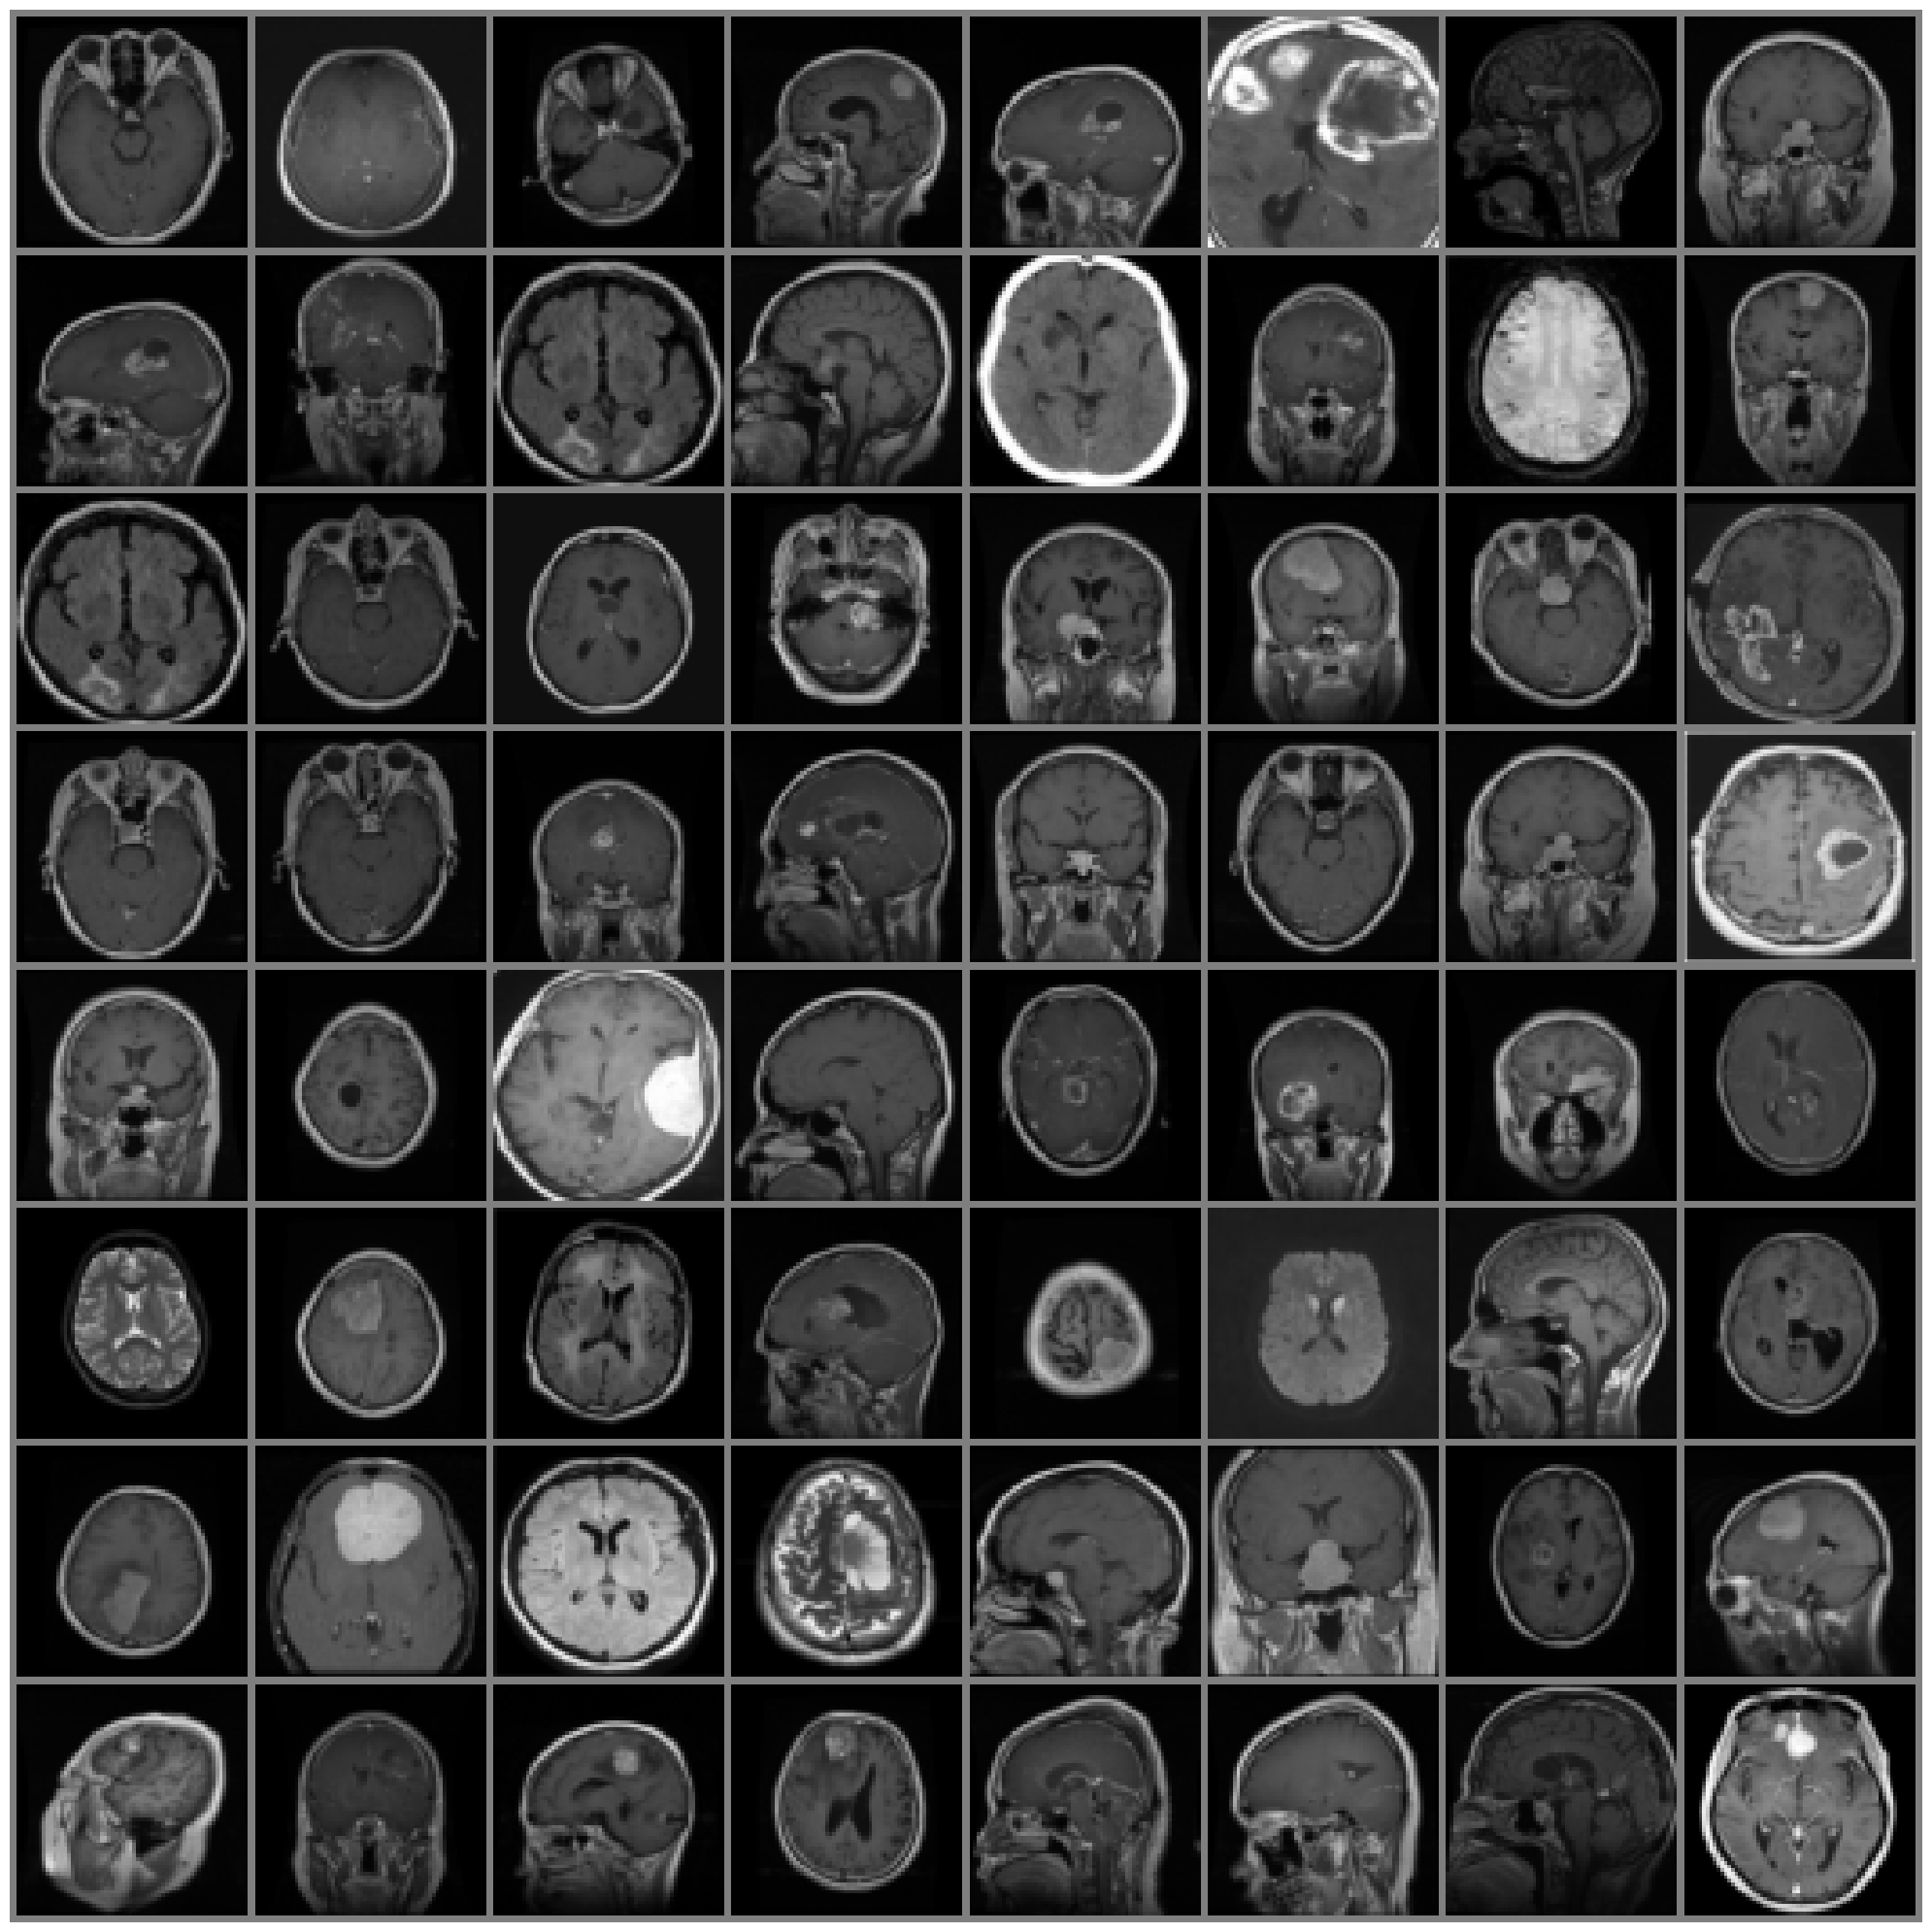

In [359]:
num_images = 64

dataiter = iter(dataloader)
images, labels = next(dataiter)

tumor_name = [tumor_mapping[int(i)] for i in labels[0][:num_images]]
section_name = [section_mapping[int(i)] for i in labels[1][:num_images]]
scan_name = [f"{tumor_name[i]}  {section_name[i]}" for i in range(len(tumor_name))]

for idx, label in enumerate(scan_name):
  print(f"{idx + 1}: {label}")
images = images[:num_images]
grid_img = vutils.make_grid(images, nrow = int(num_images ** 0.5), normalize = True, pad_value = 0.5)
plt.figure(figsize = (int(num_images ** 0.5)*2.5,(int(num_images ** 0.5)*2.5)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout();

In [338]:
class WCriticTinyVGG(nn.Module):
  def __init__(self, tumor_classes, section_classes, feature_dim):
        super(WCriticTinyVGG, self).__init__()

        self.Conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )

        self.Conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )

        self.Conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.fc_features = None

        self.fc_tumor = nn.Embedding(tumor_classes, feature_dim // 2)
        self.fc_section = nn.Embedding(section_classes, feature_dim // 2)

        self.fc_wasserstein = None

        self._initialize_fc(feature_dim)

  def _initialize_fc(self, feature_dim):
      with torch.no_grad():
          dummy = torch.randn(1, 1, feature_dim, feature_dim)
          out = self.Conv1(dummy)
          out = self.Conv2(out)
          out = self.Conv3(out)
          out = self.Conv4(out)
          flatten_dim = out.shape[1] * out.shape[2] * out.shape[3]
      self.fc_features = nn.Linear(flatten_dim, feature_dim)
      self.fc_wasserstein = nn.Linear(feature_dim * 2, 1)

  def forward(self, x, tumor_labels, section_labels):
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.Conv3(x)
    x = self.Conv4(x)

    x = torch.flatten(x, start_dim = 1)
    x = self.fc_features(x)

    tumor_emb = self.fc_tumor(tumor_labels)
    section_emb = self.fc_section(section_labels)

    x = torch.cat((x, tumor_emb, section_emb), dim=1)

    x = self.fc_wasserstein(x)

    return x


class WGeneratorTinyVGG(nn.Module):
    def __init__(self, tumor_classes, section_classes, feature_dim, latent_dim = 100):
        super(WGeneratorTinyVGG, self).__init__()

        self.latent_dim = latent_dim

        self.fc_tumor = nn.Embedding(tumor_classes, feature_dim // 2)
        self.fc_section = nn.Embedding(section_classes, feature_dim // 2)

        self.fc_input = nn.Linear(latent_dim + feature_dim, 10 * 13 * 13)

        self.TConv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 2, stride = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 2, output_padding = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 2, stride = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 1, kernel_size = 3, stride = 2, output_padding = 1),
            nn.Tanh()
        )

    def forward(self, z, tumor_labels, section_labels):
        tumor_emb = self.fc_tumor(tumor_labels)
        section_emb = self.fc_section(section_labels)

        x = torch.cat((z, tumor_emb, section_emb), dim = 1)
        x = self.fc_input(x)

        x = x.view(-1, 10, 13, 13)

        x = self.TConv1(x)
        x = self.TConv2(x)
        x = self.TConv3(x)
        x = self.TConv4(x)

        return x

crit = WCriticTinyVGG(tumor_classes = len(tumor_mapping), section_classes = len(section_mapping), feature_dim = feature_dim)
gen = WGeneratorTinyVGG(tumor_classes = len(tumor_mapping), section_classes = len(section_mapping), feature_dim = feature_dim)
print(f"Critic output shape: {crit(images, labels[0], labels[1]).shape}")
print(f'Critic parameters: {sum(p.numel() for p in crit.parameters())/1000}k')
print(f"Generator output shape: {gen(torch.randn(BS, 100), labels[0], labels[1]).shape}")
print(f'Generator parameters: {sum(p.numel() for p in gen.parameters())/1000}k')

Critic output shape: torch.Size([64, 1])
Critic parameters: 111.407k
Generator output shape: torch.Size([64, 1, 64, 64])
Generator parameters: 280.895k


In [289]:
def gradient_penalty(
    critic: torch.nn.Module,
    real_data: torch.Tensor,
    fake_data: torch.Tensor,
    tumor_labels: torch.Tensor,
    section_labels: torch.Tensor,
    lambda_gp: float = 10
):
    """
    Calculates the gradient penalty term for stabilizing WGAN-GP training.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        real_data (torch.Tensor): Batch of real data with shape (batch_size, feature_dim).
        fake_data (torch.Tensor): Batch of generated data with shape (batch_size, feature_dim).
        tumor_labels (torch.Tensor): Tumor type labels.
        section_labels (torch.Tensor): Section type labels.
        lambda_gp (float, optional): Coefficient for the gradient penalty. Default: 10.

    Returns:
        torch.Tensor: Scaled gradient penalty value to be added to the critic's loss.
    """
    batch_size = real_data.size(0)
    device = real_data.device  # Assicuriamoci di operare sullo stesso device

    # Generiamo pesi casuali per l'interpolazione
    epsilon = torch.rand(batch_size, 1, 1, 1, device=real_data.device)  # Aggiungiamo dimensioni extra
    epsilon = epsilon.expand_as(real_data)  # Ora combacia con [batch_size, channels, height, width]

    # Interpoliamo tra real_data e fake_data
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)

    # Calcoliamo il punteggio per i dati interpolati, passando entrambe le etichette
    interpolated_score = critic(interpolated, tumor_labels, section_labels)

    # Calcoliamo il gradiente
    grad_outputs = torch.ones_like(interpolated_score)
    gradients = torch.autograd.grad(
        outputs=interpolated_score,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Calcoliamo la norma del gradiente e la penalità
    gradients_norm = gradients.view(batch_size, -1).norm(2, dim=1)
    penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()

    return penalty

def critic_loss(
    critic: torch.nn.Module,
    real_data: torch.Tensor,
    fake_data: torch.Tensor,
    tumor_labels: torch.Tensor,
    section_labels: torch.Tensor,
    lambda_gp: float = 10
):
    """
    Calculates the critic loss for a WGAN-GP, including the gradient penalty.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        real_data (torch.Tensor): Batch of real data with shape (batch_size, feature_dim).
        fake_data (torch.Tensor): Batch of generated data with shape (batch_size, feature_dim).
        tumor_labels (torch.Tensor): Tumor type labels.
        section_labels (torch.Tensor): Section type labels.
        lambda_gp (float, optional): Coefficient for the gradient penalty. Default: 10.

    Returns:
        torch.Tensor: Scaled value of the critic's loss.
    """
    real_score = critic(real_data, tumor_labels, section_labels)
    fake_score = critic(fake_data, tumor_labels, section_labels)

    wasserstein_loss = fake_score.mean() - real_score.mean()

    gp = gradient_penalty(critic, real_data, fake_data, tumor_labels, section_labels, lambda_gp)
    return wasserstein_loss + gp

In [352]:
data = images
fake_data = gen(torch.randn(BS, 100), labels[0], labels[1]).detach().cpu()
#labels = (torch.randint(0, len(tumor_mapping), (BS,)), torch.randint(0, len(section_mapping), (BS,))
critic_loss(crit, data, fake_data, labels[0], labels[1])

tensor(9.8959, grad_fn=<AddBackward0>)

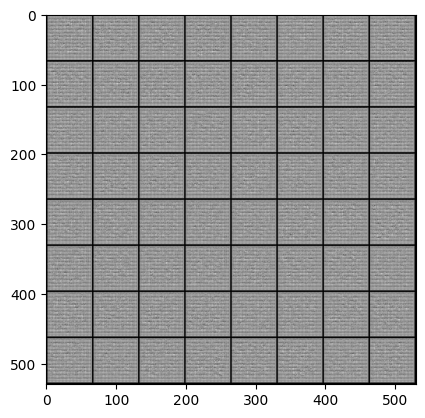

In [361]:
plt.imshow(vutils.make_grid(fake_data, nrow = 8, padding=2, normalize=True).permute(1,2,0))